# Encoding for image recognition

As we will see in this notebook,
on the relatively easy MNIST image recognition dataset,
we can use NEF decoding methods to do quite well.
However, this performance depends on a judicious choice of encoders.
This notebook explores how encoder choice
affects performance on an image categorization task.

In [1]:
%matplotlib inline
import nengo
import numpy as np

from nengo_extras.data import load_mnist, one_hot_from_labels
from nengo_extras.matplotlib import tile
from nengo_extras.vision import Gabor, Mask

rng = np.random.RandomState(9)

## Load and preprocess the data

First, we load the MNIST data,
and preprocess it to lie within the range [-1, 1]
(by default, it is in the range [0, 1]).

Then, we generate a set of training targets, `T_train`.
The dimensionality of our output
is the number of classes in the dataset, 10.
The targets are one-hot encodings of the class index of each example;
that is, for each example, we have a 10-dimensional vector
where only one element is one
(corresponding to the class of that example)
and all other elements are zero.
Five examples of this are printed in the output below.

In [2]:
# --- load the data
img_rows, img_cols = 28, 28

# pylint: disable=unbalanced-tuple-unpacking
(X_train, y_train), (X_test, y_test) = load_mnist()
X_train = 2 * X_train - 1  # normalize to -1 to 1
X_test = 2 * X_test - 1  # normalize to -1 to 1

T_train = one_hot_from_labels(y_train, classes=10)

for i in range(5):
    print("%d -> %s" % (y_train[i], T_train[i]))

5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Create the network

We now create our network.
It has one ensemble, `a`,
that encodes the input images using neurons,
and a connection `conn` out of this ensemble
that decodes the classification.

We choose not to randomize the intercepts and max rates,
so that our results are only affected
by the different encoder choices.

We create a function `get_outs` that returns
the output of the network given a `Simulator` object,
so that we can evaluate the network statically
on many images
(i.e. we don't need to run the simulator in time,
we just use the encoders and decoders
created during the build process).

In [3]:
# --- set up network parameters
n_vis = X_train.shape[1]
n_out = T_train.shape[1]

# number of hidden units
# More means better performance but longer training time.
n_hid = 1000

ens_params = dict(
    eval_points=X_train,
    neuron_type=nengo.LIFRate(),
    intercepts=nengo.dists.Choice([0.1]),
    max_rates=nengo.dists.Choice([100]),
)

solver = nengo.solvers.LstsqL2(reg=0.01)

with nengo.Network(seed=3) as model:
    a = nengo.Ensemble(n_hid, n_vis, **ens_params)
    v = nengo.Node(size_in=n_out)
    conn = nengo.Connection(
        a, v, synapse=None, eval_points=X_train, function=T_train, solver=solver
    )


def get_outs(simulator, images):
    # encode the images to get the ensemble activations
    _, acts = nengo.utils.ensemble.tuning_curves(a, simulator, inputs=images)

    # decode the ensemble activities using the connection's decoders
    return np.dot(acts, simulator.data[conn].weights.T)


def get_error(simulator, images, labels):
    # the classification for each example is index of
    # the output dimension with the highest value
    return np.argmax(get_outs(simulator, images), axis=1) != labels


def print_error(simulator):
    train_error = 100 * get_error(simulator, X_train, y_train).mean()
    test_error = 100 * get_error(simulator, X_test, y_test).mean()
    print("Train/test error: %0.2f%%, %0.2f%%" % (train_error, test_error))

## Normally distributed encoders

These are the standard encoders used in the NEF.
Since our data is high-dimensional,
they have a lot of space to cover,
and do not work particularly well,
as shown by the training and testing errors.

Samples of these encoders are shown in the plot.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Train/test error: 6.82%, 7.09%


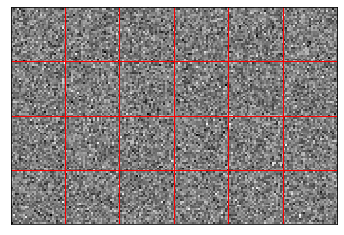

In [4]:
encoders = rng.normal(size=(n_hid, 28 * 28))
a.encoders = encoders

tile(encoders.reshape((-1, 28, 28)), rows=4, cols=6, grid=True)

with nengo.Simulator(model) as sim:
    print_error(sim)

## Normally distributed sparse encoders

The same as before, but now each encoder
has a limited receptive field.
This makes each neuron only responsible for part of the image,
and allows them to work together better to encode the whole image.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Train/test error: 5.10%, 4.83%


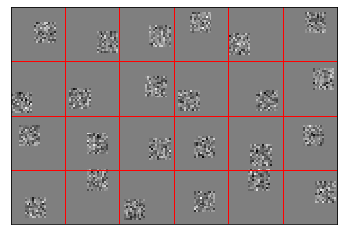

In [5]:
encoders = rng.normal(size=(n_hid, 11, 11))
encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)
a.encoders = encoders

tile(encoders.reshape((-1, 28, 28)), rows=4, cols=6, grid=True)

with nengo.Simulator(model) as sim:
    print_error(sim)

## Gabor filter encoders

Neurons in primary visual cortex
have tuning that resembles Gabor filters.
This is because natural images are somewhat smooth;
there is a correlation between a pixel's value
and that of adjacent pixels.

First, we use Gabor filters over the whole image,
which does not work particularly well because
a) each neuron is now responsible for the whole image again,
and b) the statistics of the resulting Gabor filters
do not match the statistics of the images.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Train/test error: 8.28%, 8.36%


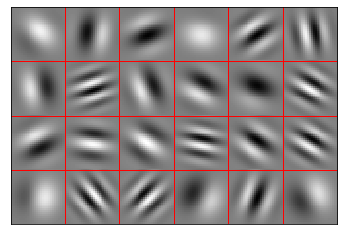

In [6]:
encoders = Gabor().generate(n_hid, (28, 28), rng=rng).reshape((n_hid, -1))
a.encoders = encoders

tile(encoders.reshape((-1, 28, 28)), rows=4, cols=6, grid=True)

with nengo.Simulator(model) as sim:
    print_error(sim)

## Sparse Gabor filter encoders

Using Gabor filters that only cover part of the image
results in the best performance.
These filters are able to work together to encode the image,
and their statistics roughly match those of the input images.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Train/test error: 2.67%, 2.80%


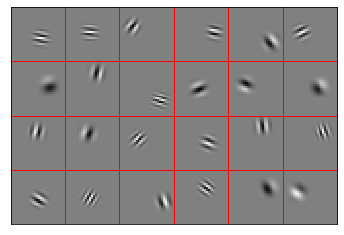

In [7]:
encoders = Gabor().generate(n_hid, (11, 11), rng=rng)
encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)
a.encoders = encoders

tile(encoders.reshape((-1, 28, 28)), rows=4, cols=6, grid=True)

with nengo.Simulator(model) as sim:
    print_error(sim)